In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import pandas as pd
import random

pso_variables = []
i = 0

# Define the sphere function
def sphere_function(x):
  return np.sum(x**2)

# Define the objective function
def objective_function(model, X, Y):
  y_pred = model.predict(X, verbose = 0)
  return np.mean((y_pred.flatten() - Y)**2)

# PSO
def update_velocity(position, velocity, best_position, global_best_position, w, c1, c2):
  inertia = w * velocity
  cognitive_component = c1 * np.random.rand(1, len(position)) * (best_position - position)
  social_component = c2 * np.random.rand(1, len(position)) * (global_best_position - position)
  new_velocity = inertia + cognitive_component + social_component
  return new_velocity

def pso(objective_function, dim, num_particles, max_iter, x_max, v_max, n_features, dim_first_layer, n_output, X, Y):
  w = 0.3
  c1 = 1.5
  c2 = 1.5
  # one particle has "dim" dimensions, each variable corresponds to: W0_1_1, W0_1_2, ... W0_2_1, ... b0_1, b0_2, ... W1_1_1, W1_1_2, ... W1_2_1, ... b1_1, b1_2, ...
  # W (0 is the first layer (the one after the input), 1 is the output layer) _ 1 (from node 1 starting layer) _ 1 (to node 1 arrival layer)
  # b (0 is the first layer (the one after the input), 1 is the output layer) _ 1 (node 1)
  particles = np.random.uniform(low=-x_max, high=x_max, size=(num_particles, dim))
  velocities = np.random.uniform(low=-v_max, high=v_max, size=(num_particles, dim))
  best_positions = np.copy(particles)
  best_scores = np.array([float('inf')] * num_particles)
  global_best_position = None
  global_best_score = float('inf')

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(dim_first_layer, activation='relu', input_dim=n_features),
      tf.keras.layers.Dense(n_output)
  ])

  for iteration in range(max_iter):
    i = 0
    for particle in particles:
      W0 = particle[:(n_features * dim_first_layer)]
      b0 = particle[(n_features * dim_first_layer):(n_features * dim_first_layer + dim_first_layer)]
      W1 = particle[(n_features * dim_first_layer + dim_first_layer):(n_features * dim_first_layer + dim_first_layer + dim_first_layer * n_output)]
      b1 = particle[(n_features * dim_first_layer + dim_first_layer + dim_first_layer * n_output):]
      model.layers[0].set_weights([W0.reshape((n_features, dim_first_layer)), np.array(b0)])
      model.layers[1].set_weights([W1.reshape((dim_first_layer, n_output)), np.array(b1)])

      fitness = objective_function(model, X, Y)

      if  fitness < best_scores[i]:
          best_scores[i] = fitness
          best_positions[i] = np.copy(particles[i])

      if  fitness < global_best_score:
          global_best_score = fitness
          global_best_position = np.copy(particles[i])

      i = i + 1

    for i in range(num_particles):
        velocities[i] = update_velocity(particles[i], velocities[i], best_positions[i], global_best_position, w, c1, c2)
        for j in range(dim):
          if velocities[i][j] > v_max:
            velocities[i][j] = v_max
          if velocities[i][j] < -v_max:
            velocities[i][j] = -v_max

        particles[i] += velocities[i]

        for j in range(dim):
          if particles[i][j] > x_max:
            particles[i][j] = x_max
          if particles[i][j] < -x_max:
            particles[i][j] = -x_max

    print("Iteration n: ", iteration, "Mean Squared Error on Training Set: ", global_best_score)

    # if (global_best_score < 0.0001):
    #     break

  return global_best_position

In [ ]:
## PSO ##
###############################
# PARAMETERS:
# Generate synthetic data for training
n_samples = 1000
n_features = 2
n_output = 1

# Build the neural network model
dim_first_layer = 2
num_iterations = 100

# Loop for iterations
for i in range(num_iterations):

    # Set the algorithm parameters
  population_size = np.random.randint(5,30)
  iterations = 10
  v_max = 1
  x_max = 8
  ###############################

  X_train = np.random.uniform(low=1, high=2, size=(n_samples, n_features))
  y_train = np.apply_along_axis(sphere_function, 1, X_train)

  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

  start = time.time()

  optimized_weights = pso(objective_function, (n_features*dim_first_layer + dim_first_layer + dim_first_layer*n_output + n_output), population_size, iterations, x_max, v_max, n_features, dim_first_layer, n_output, X_train, y_train)

  end = time.time()
  time_pso = end - start

  # Set the optimal weights to the model
  model = tf.keras.Sequential([
        tf.keras.layers.Dense(dim_first_layer, activation='relu', input_dim=n_features),
        tf.keras.layers.Dense(n_output)
  ])

  W0 = optimized_weights[:(n_features * dim_first_layer)]
  b0 = optimized_weights[(n_features * dim_first_layer):(n_features * dim_first_layer + dim_first_layer)]
  W1 = optimized_weights[(n_features * dim_first_layer + dim_first_layer):(n_features * dim_first_layer + dim_first_layer + dim_first_layer * n_output)]
  b1 = optimized_weights[(n_features * dim_first_layer + dim_first_layer + dim_first_layer * n_output):]
  model.layers[0].set_weights([W0.reshape((n_features, dim_first_layer)), np.array(b0)])
  model.layers[1].set_weights([W1.reshape((dim_first_layer, n_output)), np.array(b1)])


  # Evaluate the model on the test set
  y_pred_test = model.predict(X_test)
  mse_test = np.mean((y_pred_test.flatten() - y_test)**2)
  print(f"Mean Squared Error on Test Set: {mse_test}")


  variables = [[population_size, iterations, v_max, x_max, time_pso, mse_test]]
  pso_variables = pso_variables + variables
  i = i+1
  print(i)

print(pso_variables)


Iteration n:  0 Mean Squared Error on Training Set:  1.658009619578965
Iteration n:  1 Mean Squared Error on Training Set:  0.8247589029336737
Iteration n:  2 Mean Squared Error on Training Set:  0.8247589029336737
Iteration n:  3 Mean Squared Error on Training Set:  0.8247589029336737
Iteration n:  4 Mean Squared Error on Training Set:  0.8247589029336737
Iteration n:  5 Mean Squared Error on Training Set:  0.8247589029336737
Iteration n:  6 Mean Squared Error on Training Set:  0.7177692165716824
Iteration n:  7 Mean Squared Error on Training Set:  0.7141167610789699
Iteration n:  8 Mean Squared Error on Training Set:  0.6861255957000867
Iteration n:  9 Mean Squared Error on Training Set:  0.5379510320057058
7/7 [==============================] - 0s 2ms/step
Mean Squared Error on Test Set: 0.49543305827829776
1
Iteration n:  0 Mean Squared Error on Training Set:  3.670162003623283
Iteration n:  1 Mean Squared Error on Training Set:  3.3224018212478734
Iteration n:  2 Mean Squared Erro

In [ ]:
df_pso = pd.DataFrame(data = pso_variables)

print(df_pso)

with open('/content/sphere_function.txt', 'a') as file:
        df_pso.to_csv(file, sep = '\t', index=False, mode= 'a', header = ['x','x','x','x','x','x'])

     0   1  2  3          4         5
0   25  10  1  8  41.058891  0.495433
1   19  10  1  8  25.692365  0.889885
2   22  10  1  8  28.741032  0.875092
3   21  10  1  8  26.314809  1.131866
4   24  10  1  8  30.830220  1.027902
..  ..  .. .. ..        ...       ...
95  20  10  1  8  24.976018  0.238269
96  23  10  1  8  27.526322  1.561351
97  24  10  1  8  29.448093  1.542477
98  13  10  1  8  18.954308  1.439500
99  29  10  1  8  38.092635  1.621489

[100 rows x 6 columns]


Epoch 1/200
80/80 [==============================] - 1s 3ms/step - loss: 34.7754
Epoch 2/200
80/80 [==============================] - 0s 2ms/step - loss: 27.4009
Epoch 3/200
80/80 [==============================] - 0s 2ms/step - loss: 23.8785
Epoch 4/200
80/80 [==============================] - 0s 2ms/step - loss: 21.9922
Epoch 5/200
80/80 [==============================] - 0s 2ms/step - loss: 20.7517
Epoch 6/200
80/80 [==============================] - 0s 2ms/step - loss: 19.9162
Epoch 7/200
80/80 [==============================] - 0s 2ms/step - loss: 19.2289
Epoch 8/200
80/80 [==============================] - 0s 2ms/step - loss: 18.6035
Epoch 9/200
80/80 [==============================] - 0s 3ms/step - loss: 18.0040
Epoch 10/200
80/80 [==============================] - 0s 3ms/step - loss: 17.4212
Epoch 11/200
80/80 [==============================] - 0s 2ms/step - loss: 16.8517
Epoch 12/200
80/80 [==============================] - 0s 2ms/step - loss: 16.2975
Epoch 13/200
80/80 [=====

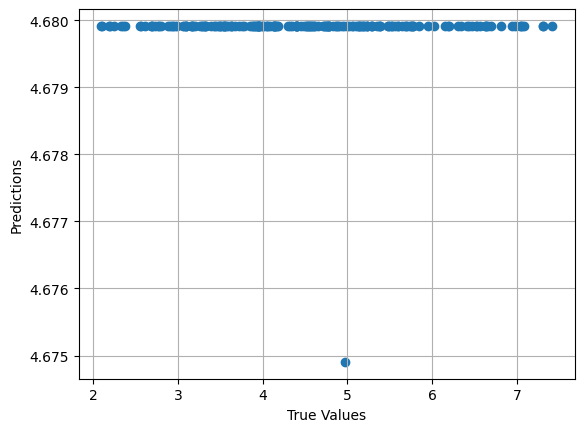

31.36999011039734


In [ ]:
## ADAM ##

# Generate synthetic data for training
n_samples = 1000
n_features = 2
n_output = 1

X_train = np.random.uniform(low=1, high=2, size=(n_samples, n_features))
y_train = np.apply_along_axis(sphere_function, 1, X_train)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Build the neural network model
dim_first_layer = 2

model = tf.keras.Sequential([
      tf.keras.layers.Dense(dim_first_layer, activation='relu', input_dim=n_features),
      tf.keras.layers.Dense(n_output)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= opt , loss='mean_squared_error')

start = time.time()

model.fit(X_train, y_train, epochs=200, batch_size = 10)

end = time.time()

print(model.get_weights())

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = np.mean((y_pred_test.flatten() - y_test)**2)
print(f"Mean Squared Error on Test Set: {mse_test}")

# Plot the true values vs predictions
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid()
plt.show()

print(end - start)